In [75]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sys.path.append('../third_party')
sys.path.append('../methods')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data generation

In [7]:
from models import GaussianMixture, ConcentricCircles, ConcentricCircles2, ConcentricCirclesMixture, BinomialModel

random_state = 2022

model_name = "circles-mix"

if model_name == "GaussianMixture":
    p = 20        # Number of features
    a = 0.25         # Signal amplitude
    model = GaussianMixture(p, a, random_state=random_state)
    purity = 0.8    # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "circles-mix":
    p = 1000        # Number of features
    a = 0.5        # Signal amplitude
    model = ConcentricCirclesMixture(p, a, random_state=random_state)
    purity = 0.5      # Proportion of inliers
    n = 500          # Number of observations

elif model_name == "circles":
    p = 1000        # Number of features
    a = 0.99        # Signal amplitude
    model = ConcentricCircles(p, a, random_state=random_state)
    purity = 0.9      # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "BinomialModel":
    p = 100        # Number of features
    a = 3          # Signal amplitude
    model = BinomialModel(p, a, random_state=random_state)
    purity = 0.9     # Proportion of inliers
    n = 1000          # Number of observations
    
else:
    print("Error: unknown model name!")
    
    
n_test = 100     # Number of test points
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity)
X_test, Y_test = model.sample(n_test, purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 250.
Number of outliers in training/calibration data: 250.
Number of inliers in test data: 50.
Number of outliers in test data: 50.


## Conformal p-values via one-class classification

In [8]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf', degree=3),
                 svm.OneClassSVM(kernel='sigmoid', degree=3),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[0]

Fitting the black-box model on 125 data points... done.
Calculating conformity scores for 125 hold-out data points... done.
Calculating conformity scores for 100 test points... done.


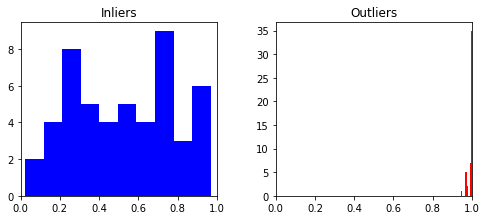

In [9]:
from methods_split import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conformal p-values via weighted one-class classification

Fitting a one-class classification model on 125 data points... done.
Fitting a one-class classification model on 125 data points... done.


100%|██████████| 100/100 [00:00<00:00, 1368.94it/s]


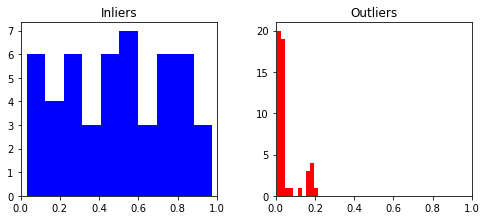

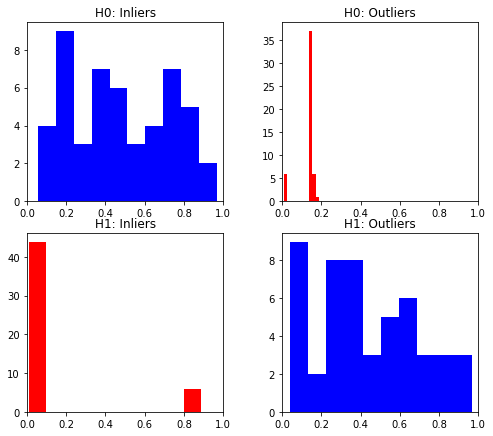

0.056666666666666664

In [10]:
from methods_split import IntegrativeConformal
from sklearn.linear_model import SGDOneClassSVM

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one_in = [svm.OneClassSVM(kernel='rbf', gamma=0.001)
               ]
bboxes_one_out = [svm.OneClassSVM(kernel='rbf', gamma=0.001)
                ] 

# Compute the p-values
method_woc = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one_in, bboxes_one_out=bboxes_one_out,
                                       calib_size=0.5, tuning=True)
pvals_woneclass, pvals_woneclass_0, pvals_woneclass_1 = method_woc.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Plot the preliminary p-values
fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0,0].hist(pvals_woneclass_0[Y_test==0], color="blue")
axs[0,1].hist(pvals_woneclass_0[Y_test==1], color="red")  
axs[1,0].hist(pvals_woneclass_1[Y_test==0], color="red")
axs[1,1].hist(pvals_woneclass_1[Y_test==1], color="blue")  
axs[0,0].title.set_text('H0: Inliers')
axs[0,1].title.set_text('H0: Outliers')
axs[1,0].title.set_text('H1: Inliers')
axs[1,1].title.set_text('H1: Outliers')
axs[0,0].set_xlim(0,1)
axs[0,1].set_xlim(0,1)
axs[1,0].set_xlim(0,1)
axs[1,1].set_xlim(0,1)
plt.show()

np.mean(pvals_woneclass[Y_test==1])

## Measure correlation

In [145]:
# Choose a family of one-class classifiers
bbox_occ_list = {'SVM-rbf':svm.OneClassSVM(kernel='rbf', degree=3),
                 'SVM-sig':svm.OneClassSVM(kernel='sigmoid', degree=3),
                 'SVM-poly':svm.OneClassSVM(kernel='poly', degree=3)
                }


p = 1000        # Number of features
a = 0.7        # Signal amplitude
purity = 0.5      # Proportion of inliers
n = 200          # Number of observations
    
n_test = 2      # Size of test set
purity_test = 0.5 # Proportion of inliers in test set

model = BinomialModel(p, a, random_state=0)
offset = model.calculate_offset(purity)

def measure_correlation(n, random_state):
    model = BinomialModel(p, a, random_state=random_state)
    X, Y = model.sample(n, purity, offset=offset)
    X_test, Y_test = model.sample(n_test, 1, offset=offset)

    # Extract the inliers from the data
    X_in = X[Y==0]
    X_out = X[Y==1]

    # Compute the OCC p-values
    method_occ = OneClassConformal(X_in, bbox_occ_list['SVM-rbf'], calib_size=0.5, verbose=False)
    pvals_occ = method_occ.compute_pvalues(X_test)
    
    # Compute the integrative p-values
    method_int = IntegrativeConformal(X_in, X_out, 
                                      bboxes_one=list(bbox_occ_list.values()), 
                                      bboxes_one_out=list(bbox_occ_list.values()),
                                      calib_size=0.5, verbose=False, progress=False, tuning=True)
    pvals_int = method_int.compute_pvalues(X_test)
    return pvals_int, pvals_occ

In [146]:
n_seq = np.array([20,50,100])
corr_seq_int = -np.ones((len(n_seq),))
corr_seq_occ = -np.ones((len(n_seq),))
num_rep = 1000

for i in tqdm_notebook(range(len(n_seq))):
    n = n_seq[i]
    P_vals_int = np.zeros((num_rep, n_test))
    P_vals_occ = np.zeros((num_rep, n_test))
    for r in tqdm_notebook(range(num_rep)):
        P_vals_int[r], P_vals_occ[r] = measure_correlation(n, r)
    P_cov_int = np.corrcoef(P_vals_int.T)
    P_cov_occ = np.corrcoef(P_vals_occ.T)
    corr_seq_int[i] = P_cov_int[0,1]
    corr_seq_occ[i] = P_cov_occ[0,1]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

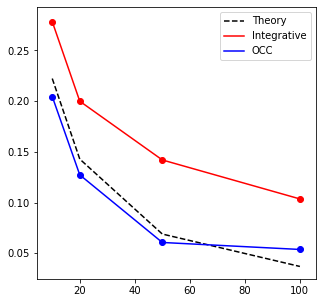

In [117]:
n_seq = np.array([10,20,50,100])
corr_seq_theory = 1.0/(purity*0.5*n_seq+2)

plt.plot(n_seq, corr_seq_theory, color="Black", label="Theory", linestyle="dashed")
plt.scatter(n_seq, corr_seq_int, color="Red")
plt.plot(n_seq, corr_seq_int, color="Red", label="Integrative")
plt.scatter(n_seq, corr_seq_occ, color="Blue")
plt.plot(n_seq, corr_seq_occ, color="Blue", label="OCC")
plt.legend()
plt.show()

In [96]:
corr_seq_int

array([ 0.35321721,  0.17907975,  0.18733784,  0.18167654, -0.0172817 ,
       -0.09226477])